In [38]:
# requirements: pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', rc={'figure.dpi':150})
df = pd.read_csv('/content/Dataset.csv')
print(df.columns.tolist())


['Month', 'FUE ID ', 'Name', 'Surgery Date ', 'Month-Year', 'Latest visit date', 'Link', 'UGC Link', 'Case Type', 'Age', 'Age Bin', 'Grade', 'Grafts', 'Location', 'Branch', 'Type (Location)', 'Language ', 'Patient Result', 'Communication Skill', 'Patients Looks ', 'Consent Form', 'Consent', 'Name To Be Hidden', 'Video shoot', 'Testimonial Shoot Type', 'Creative Shoot Type', '1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month', '8 Month', '9 Month', '10 Month', '11 Month', '12 Month', '13 Months ', 'Patient Approval', 'Unnamed: 40', 'Edited Folder link', 'Remarks']


In [41]:
df = df.drop_duplicates(subset=['FUE ID '], keep='first')

In [42]:
df['Surgery Date '] = pd.to_datetime(df['Surgery Date '], dayfirst=True, errors='coerce')
df['Grafts'] = pd.to_numeric(df['Grafts'], errors='coerce')
df['Patient Result'] = df['Patient Result'].astype(str).str.strip()
print(df.dtypes)

Month                             object
FUE ID                            object
Name                              object
Surgery Date              datetime64[ns]
Month-Year                        object
Latest visit date                 object
Link                              object
UGC Link                          object
Case Type                         object
Age                               object
Age Bin                           object
Grade                             object
Grafts                           float64
Location                          object
Branch                            object
Type (Location)                   object
Language                          object
Patient Result                    object
Communication Skill               object
Patients Looks                    object
Consent Form                      object
Consent                           object
Name To Be Hidden                 object
Video shoot                       object
Testimonial Shoo

/tmp/ipython-input-3137720653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Surgery Date '] = pd.to_datetime(df['Surgery Date '], dayfirst=True, errors='coerce')
/tmp/ipython-input-3137720653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grafts'] = pd.to_numeric(df['Grafts'], errors='coerce')


In [44]:
# 3. Derived columns
# Convert text to datetime

df['Year'] = df['Surgery Date '].dt.year
df['Month_Num'] = df['Surgery Date '].dt.month
df['Month_Year'] = df['Surgery Date '].dt.to_period('M').astype(str)

In [45]:
def kpi_summary(df):
    kpis = {}
    kpis['total_patients'] = int(df['FUE ID '].nunique())
    kpis['surgeries_this_month'] = int(df[df['Month_Year'] == df['Month_Year'].max()].shape[0])
    kpis['avg_grafts'] = float(df['Grafts'].mean())
    kpis['good_result_rate'] = float((df['Patient Result'] == 'Good').mean())
    return kpis

print(kpi_summary(df))


{'total_patients': 2053, 'surgeries_this_month': 202, 'avg_grafts': 3921.7088541666667, 'good_result_rate': 0.008276533592989289}


In [48]:
df = df.rename(columns={
    "1 Month": "Followup_M1",
    "2 Month": "Followup_M2",
    "3 Month": "Followup_M3",
    "4 Month": "Followup_M4",
    "5 Month": "Followup_M5",
    "6 Month": "Followup_M6",
    "7 Month": "Followup_M7",
    "8 Month": "Followup_M8",
    "9 Month": "Followup_M9",
    "10 Month": "Followup_M10",
    "11 Month": "Followup_M11",
    "12 Month": "Followup_M12",
    "13 Months ": "Followup_M13"   # notice extra space & plural "Months"
})

print(df.columns.tolist())

['Month', 'FUE ID ', 'Name', 'Surgery Date ', 'Month-Year', 'Latest visit date', 'Link', 'UGC Link', 'Case Type', 'Age', 'Age Bin', 'Grade', 'Grafts', 'Location', 'Branch', 'Type (Location)', 'Language ', 'Patient Result', 'Communication Skill', 'Patients Looks ', 'Consent Form', 'Consent', 'Name To Be Hidden', 'Video shoot', 'Testimonial Shoot Type', 'Creative Shoot Type', 'Followup_M1', 'Followup_M2', 'Followup_M3', 'Followup_M4', 'Followup_M5', 'Followup_M6', 'Followup_M7', 'Followup_M8', 'Followup_M9', 'Followup_M10', 'Followup_M11', 'Followup_M12', 'Followup_M13', 'Patient Approval', 'Unnamed: 40', 'Edited Folder link', 'Remarks', 'Year', 'Month_Num', 'Month_Year']


In [50]:
followup_cols = [
    "Followup_M1","Followup_M2","Followup_M3","Followup_M4","Followup_M5",
    "Followup_M6","Followup_M7","Followup_M8","Followup_M9","Followup_M10",
    "Followup_M11","Followup_M12","Followup_M13"
]

for col in followup_cols:
    df[col] = df[col].astype(str).str.strip().str.upper().map({"TRUE": 1, "FALSE": 0})



In [54]:
# Followup columns assumed named Followup_M1..Followup_M13 as integers 0/1
followup_cols = [c for c in df.columns if c.startswith('Followup_M')]
df['Followup_Count'] = df[followup_cols].sum(axis=1)
df['Followup_Completed'] = (df['Followup_Count'] >= 12).astype(int)
df['Has_Any_Followup'] = (df['Followup_Count'] > 0).astype(int)




In [56]:
# 5. Retention summary (month-level)
months = range(1, 14)
retention = []
total_patients = df['FUE ID '].nunique()
for m in months:
    col = f'Followup_M{m}'
    if col in df.columns:
        attended = int(df[col].sum())
    else:
        attended = 0
    retention.append({'month': m, 'attended': attended, 'retention_pct': attended/total_patients})
ret_df = pd.DataFrame(retention)

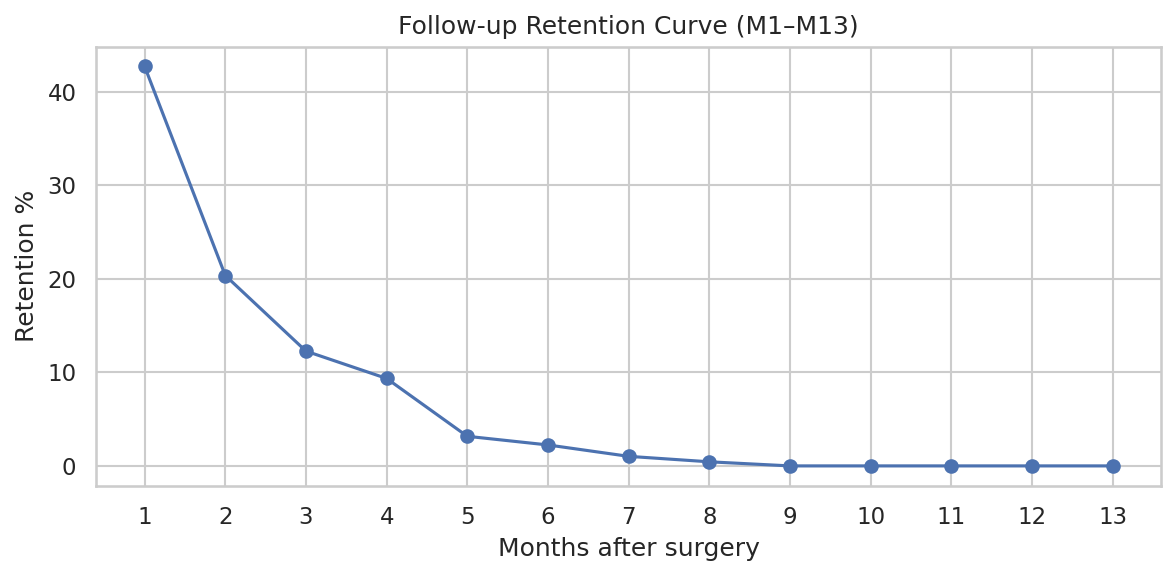

In [58]:
# Plot retention curve
plt.figure(figsize=(8,4))
plt.plot(ret_df['month'], ret_df['retention_pct']*100, marker='o')
plt.xticks(months)
plt.xlabel('Months after surgery')
plt.ylabel('Retention %')
plt.title('Follow-up Retention Curve (M1–M13)')
plt.grid(True)
plt.tight_layout()

plt.show()

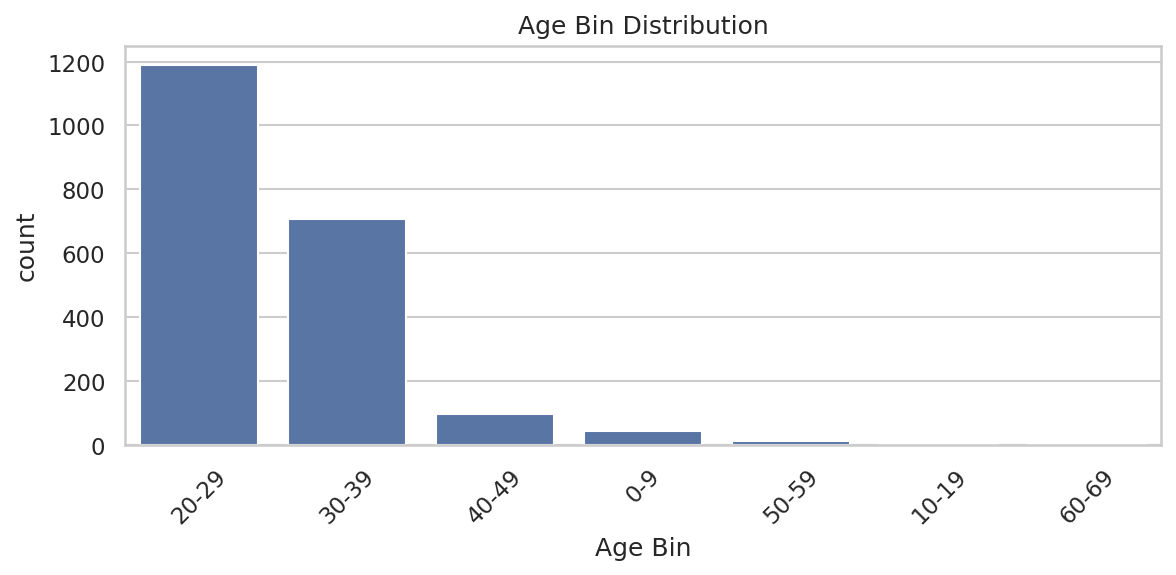

In [61]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Age Bin', order=df['Age Bin'].value_counts().index)
plt.title('Age Bin Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


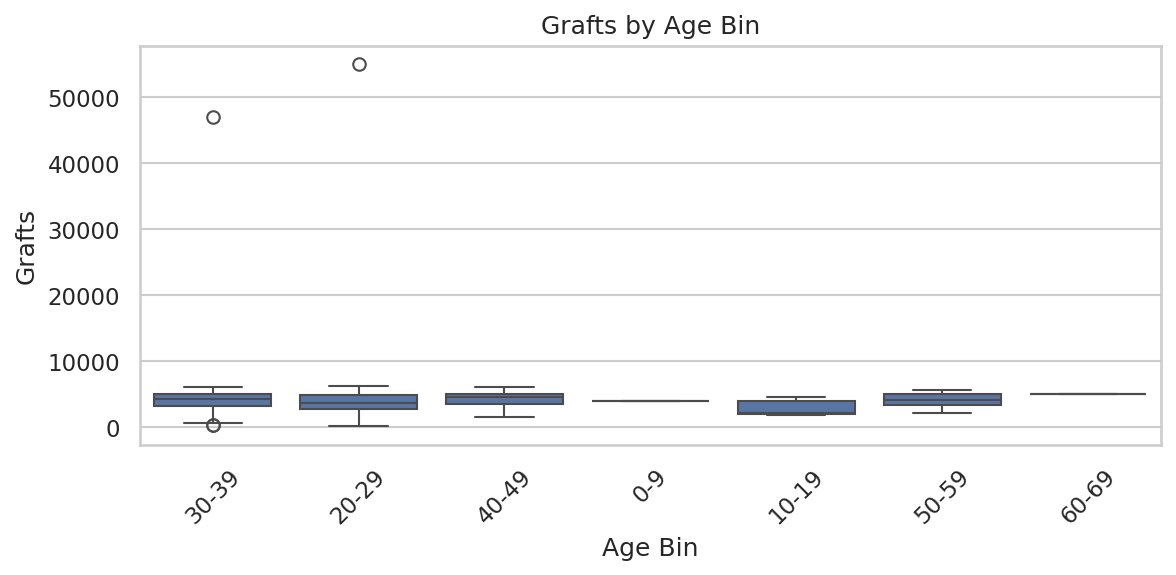

In [62]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='Age Bin', y='Grafts')
plt.title('Grafts by Age Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()